In [1]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.io import wavfile
import warnings
from difflib import SequenceMatcher
%matplotlib notebook


def read_arduino(ser,inputBufferSize):
#    data = ser.readline(inputBufferSize)
    data = ser.read(inputBufferSize)
    out =[(int(data[i])) for i in range(0,len(data))]
    return out

def process_data(data):
    data_in = np.array(data)
    result = []
    i = 1
    while i < len(data_in)-1:
        if data_in[i] > 127:
            # Found beginning of frame
            # Extract one sample from 2 bytes
            intout = (np.bitwise_and(data_in[i],127))*128
            i = i + 1
            intout = intout + data_in[i]
            result = np.append(result,intout)
        i=i+1
    return result

In [27]:
with open ("Book3.csv", "r") as f:
    data = f.read()
#data.split("\n")
qbank = []
for line in data.split("\n"):
    print(line)
    q,a = line.split(",")
    if a[0].lower() == "t":
        qbank.append((q,True))
    else:
        qbank.append((q,False))

for line in qbank:
    print(line)

ï»¿The universe is 13.8 billion years old.,TRUE
The constellation Virgo is the hottest place in the universe.,TRUE
Jupiter is the largest planet in our solar system.,TRUE
Apollo 17 was the last NASA manned mission space filght to the moon.,TRUE
There is only one moon in our solar system.,FALSE
The shortest space flight was 25 minutes.,FALSE
Light cannot escape from a black hole.,TRUE
There are 9 planets in the solar system.,FALSE
Red supergiant stars are the largest type of stars in the universe.,TRUE
Elliptical galaxies are not the most common galaxies in the universe.,FALSE
An ant can fit 100 times its own weight.,FALSE
8128 is a perfect number.,TRUE
There are 24 time zones in the world.,TRUE
AB postitive is the rarest blood type in humans.,FALSE
An octopus has only one heart.,FALSE
Hydrogen is the first element on the periodic table.,TRUE
There are seven colors in a rainbow.,TRUE
Dolphins cannot smell.,TRUE
Liver is the largest organ of human body.,FALSE
Celsius and Fahrenheit are e

In [3]:
def clean_function(R):
    Fs = 10000;
    T = np.linspace(1, len(R), len(R))/Fs
    nffte = len(T)
    X = np.fft.fft(R,nffte)
    X = np.fft.fftshift(X)

    f = np.linspace(-nffte/2,nffte/2-1,len(X))*Fs/nffte


    X[abs(f)>15]=0

    R1 = np.fft.ifftshift(X)
    R = np.fft.ifft(R1)
    return R

def normalize(R):
    #transfer to normalize graph
    max_r = max(R)
    min_r = min(R)
    if abs(min_r) > max_r:
        max_r = abs(min_r)
    for index in range(len(R)):
        R[index] /= max_r
    plt.figure()
    plt.plot(R)
    return R

In [4]:
#detect events
def event_function(R,Fs):    
    window_size = Fs*1
    start_point = 0
    event_list = []
    var_list = []
    var_start = 0
    
    while True:
        if var_start+len(R)/Fs/10 >= len(R):
            break
        win = R[int(var_start):int(var_start+Fs/2)]
        var_list.append(np.var(win))
        var_start+=len(R)/Fs/10

    while True:
        if start_point+window_size<=len(R):
            window = R[int(start_point):int((start_point+window_size/2))]
            window_var = np.var(window)
            if window_var >= 0.062:
                event_list.append(start_point)
                start_point+=Fs*1.25
            else:
                start_point += len(R)/Fs/10
            if start_point+len(R)/Fs/10 >=len(R):
                break
        else:
            break
    print(len(event_list))
    print(event_list)
    plt.figure()
    plt.plot(var_list)
    return event_list,var_list
#detect direction
def direction_function(event_list,Fs):    
    direction_list = []
    for event in event_list:
        event_period = R[int(event):int(event+Fs/2)]
        max_pos=np.argwhere(R==max(event_period))
        min_pos=np.argwhere(R==min(event_period))
        if max_pos <min_pos:
            direction_list.append("L")
        else:
            direction_list.append("R")
    print(direction_list)
    print(np.mean(var_list))
    return direction_list
#machine learning
def point_interval(event_list,R,Fs):
    result_list = []
    for ele in event_list:
        result_list.append(R[int(ele):int(ele+Fs/2)])
    return result_list   
def randomforest(event_list):    
    features = np.array(event_list).astype(float)
    labels = [1,1,0,0,0,0,1,1,1,1,0,0,0,0]
    labels = np.array(labels)
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    rf.fit(features,labels)
    return rf



<IPython.core.display.Javascript object>


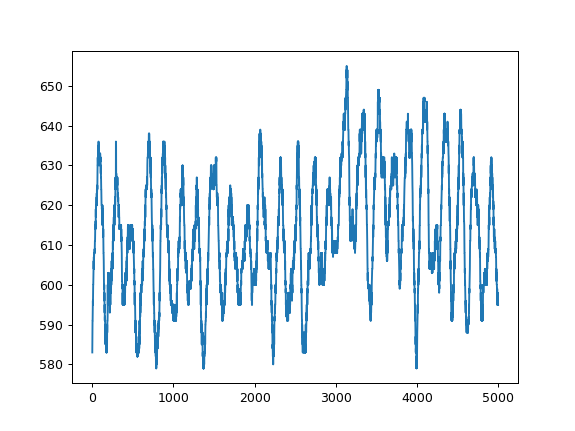

In [28]:
# Read example data
baudrate = 230400
cport = 'COM6'  # set the correct port before you run it
#cport = '/dev/tty.usbmodem141101'  # set the correct port before run it
ser = serial.Serial(port=cport, baudrate=baudrate)    
# take example data
inputBufferSize = 10000 # 20000 = 1 second
ser.timeout = inputBufferSize/20000.0  # set read timeout
#ser.set_buffer_size(rx_size = inputBufferSize)
data = read_arduino(ser,inputBufferSize)
data_plot = process_data(data)
plt.figure()
plt.plot(data_plot)
plt.show()

<IPython.core.display.Javascript object>


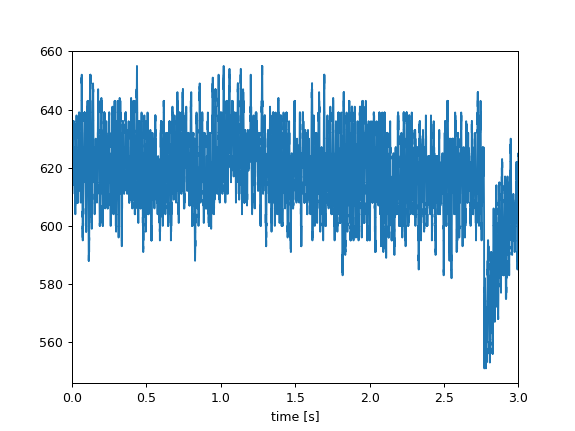

'fig3 = plt.figure(3)\nplt.plot(times,R)'

In [29]:
# take continuous data stream 
inputBufferSize = 5000 # keep betweein 2000-20000
#ser.timeout = inputBufferSize/20000.0  # set read timeout, 20000 is one second
#ser.set_buffer_size(rx_size = inputBufferSize)

#matplotlib notebook

total_time = 20.0; # time in seconds [[1 s = 20000 buffer size]]
max_time = 3; # time plotted in window [s]
N_loops = 20000.0/inputBufferSize*total_time

T_acquire = inputBufferSize/20000.0    # length of time that data is acquired for 
N_max_loops = max_time/T_acquire    # total number of loops to cover desire time window



fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlim(0, 1024)
plt.ion()
fig.show()
fig.canvas.draw()

datat = [];




for k in range(0,int(N_loops)):
    data = read_arduino(ser,inputBufferSize)
    data_temp = process_data(data)
    if k <= N_max_loops:
        if k==0:
            data_plot = data_temp
        else:
            data_plot = np.append(data_temp,data_plot)
        t = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot).size)
    else:
        data_plot = np.roll(data_plot,len(data_temp))
        data_plot[0:len(data_temp)] = data_temp
    t = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot).size)
    
    
    
    
#    plt.xlim([0,max_time])

    ax1.clear()
    ax1.set_xlim(0, max_time)
    plt.xlabel('time [s]')
    ax1.plot(t,data_plot)
    fig.canvas.draw()    
    plt.show()
    

    datat = np.append(datat,data_plot)

times = np.linspace(0,10,len(datat))  

R = clean_function(datat) 

avgR = sum(R)/len(R)
    
R = R-avgR



maxR = max(abs(R))





In [31]:
# take continuous data stream 
inputBufferSize = 5000 # keep betweein 2000-20000
#ser.timeout = inputBufferSize/20000.0  # set read timeout, 20000 is one second
#ser.set_buffer_size(rx_size = inputBufferSize)
warnings.filterwarnings("ignore")

import time
r = [];
rime = [];
RTtrue = [];
reset = 0;
reset_2 = 0;
reset_3 = 0;

#matplotlib notebook
import random


p = 0
random.shuffle(qbank)
correct = 0
s = 0



total_time = 60.0; # time in seconds [[1 s = 20000 buffer size]]
max_time = 3; # time plotted in window [s]
N_loops = 20000.0/inputBufferSize*total_time

T_acquire = inputBufferSize/20000.0    # length of time that data is acquired for 
N_max_loops = max_time/T_acquire    # total number of loops to cover desire time window





print("Left = True, Right = False\n")
q,a = qbank[p]
print(p+1,q)




for k in range(0,int(N_loops)):
    
    data = read_arduino(ser,inputBufferSize)
    data_temp = process_data(data)
    if k <= N_max_loops:
        if k==0:
            data_plot = data_temp
        else:
            data_plot = np.append(data_temp,data_plot)
        t = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot).size)
    else:
        data_plot = np.roll(data_plot,len(data_temp))
        data_plot[0:len(data_temp)] = data_temp
    t = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot).size)
    
    if k >= 20:
        
        

        X = clean_function(data_plot)-avgR

        Y = X/maxR

        wlength= 1/20000*inputBufferSize;

        T = np.linspace(0,wlength,len(Y))+wlength*(k);
        
    

        TMax = max(T);  # maximum time recorded
        TWindow = 0.05;    # observation interval
        threshold_level = 0.20;
        dT = T[1]-T[0]; # dT
        NWindow = round(TWindow/dT);   # number of points in Window




        b = round(wlength/TWindow)
        

        for i in range(0,int(b)):
            
            if reset_2 != 0:
                if reset_2 % 140 == 0:
                    #print new question
                    q,a = qbank[p]
                    #print ('\n')
                    print(p+1,q)
                    reset_2 = 0;
                elif reset_2 == 20:
                    print('6 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;
                elif reset_2 == 40:
                    print('5 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;
                elif reset_2 == 60:
                    print('4 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;
                elif reset_2 == 80:
                    print('3 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;
                elif reset_2 == 100:
                    print('2 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;
                elif reset_2 == 120:
                    print('1 second\r',end='',flush=True)
                    reset_2 = reset_2 + 1;

                else:
                    reset_2 = reset_2 + 1;

            elif reset_2 == 0:
                if reset != 0:
                    if reset % 80 == 0:
                        #print new question
                        q,a = qbank[p]
                        #print('\n')
                        print(p+1,q)
                        reset = 0;
                    elif reset == 20:
                        print('3 second\r',end='',flush=True)
                        reset = reset + 1;
                    elif reset == 40:
                        print('2 second\r',end='',flush=True)
                        reset = reset + 1;
                    elif reset == 60:
                        print('1 second\r',end='',flush=True)
                        reset = reset + 1;
                    else:
                        reset = reset + 1;
            
    
            
            if reset ==0:
                if reset_2 ==0:
                    
                    r = [];
                    rime = [];

                    window_index_beginning = int(1+NWindow*(i)); # test if needs 1 or not
                    window_index_end = int(NWindow+NWindow*(i));


                    blinkstest = max(abs(Y[window_index_beginning:window_index_end]));


                    average_signal = sum(Y[window_index_beginning:window_index_end])/(window_index_end-window_index_beginning+1)
                    user_answer = np.array(Y[int(window_index_beginning):int(window_index_end)])

                    if reset_3 == 0:

                        if blinkstest > 1:
                            print('You skipped')
                            print(q,a,'\n')
                            #r = np.append(r,'Blink');
                            r = np.append(r,'5')
                            rime = np.append(rime,[TWindow*(i+1)+wlength*(k)]);
                            #reset = 1
                            reset_2 = 1;
                            reset_3 = 1;
                            p += 1
                            s += 1
                            
                    
                    
                    
                    
                    
                    if reset_2 == 0:
                        if average_signal>threshold_level:

                            #r = np.append(r,'Left');
                            r = np.append(r,'1')
                            rime = np.append(rime,[TWindow*(i+1)+wlength*(k)]);
                            reset = 1;
                            usera= True
                            #usera = bool(usera)
                            # --- set user = none, while it's none, have the spiker box scan for signals; set a while loop to 
                            if usera == bool(a):
                                print("You said True, that is correct")
                                correct+= 1
                                #print(q,a)

                            else:
                                print("You said True, that is Incorrect")
                                #print(q,a)

                            print(q,a,'\n')
                            p += 1
                            #q,a = qbank[p]    
                            #print(p+1,q)
                            reset_3 = 0

                        elif average_signal<-threshold_level:

                            #r = np.append(r,'Right');
                            r = np.append(r,'0')
                            rime = np.append(rime,[TWindow*(i+1)+wlength*(k)]);
                            
                            reset = 1;
                            usera= False
                            #usera = bool(usera)
                            # --- set user = none, while it's none, have the spiker box scan for signals; set a while loop to 
                            if usera == bool(a):
                                print("You said False, that is correct")
                                #print(q,a)
                                correct+= 1  

                            else:
                                print("You said False, that is incorrect")
                                #print(q,a)
                                #d.pop(a[0])
                            print(q,a,'\n')
                            p += 1
                            #q,a = qbank[p]
                            #print(p+1,q)
                            reset_3 = 0
                        #else:
                            #reset = reset + 1


                    RT = np.stack((r, rime))

                    RT = RT.transpose()  


                    RTtrue = np.append(RTtrue,RT)

                    
                    

print(RTtrue)
print("Time is up!", "Your Score:", correct, "Out of", p-s, ", Skipped:", s)

Left = True, Right = False

1 Saint Patrick's Day was originally associated with color red.
You said True, that is Incorrect
Saint Patrick's Day was originally associated with color red. False 

2 There are 9 planets in the solar system.
You skipped
There are 9 planets in the solar system. False 

3 The name for the Greek goddess of victory is called Nike.
You said True, that is correct
The name for the Greek goddess of victory is called Nike. True 

4 The shortest space flight was 25 minutes.


SerialException: ClearCommError failed (PermissionError(13, 'The device does not recognize the command.', None, 22))